In [1]:
import os
from IPython.display import display

# ROOT contais the project directory 
os.chdir(os.path.dirname(os.getcwd()))

In [701]:
# Built-In libraries
import os
import copy
import itertools

# External libraries
import PIL
import torch
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import scipy.cluster.hierarchy as shc
import sklearn
from sklearn.cluster import AgglomerativeClustering

# Local libraries
from src.plots import plot_color_bar


class Fundus():
    def __init__(self, source=False, **kwargs):
        # Attributes
        self.im = None
        self._pixels  = None
        self._palette = None
        
        # Constructors
        if isinstance(source, str):
            self._image_from_file(source)

        if isinstance(source, np.ndarray):
            self._image_from_pixels(source, **kwargs)
            
        if isinstance(source, PIL.Image.Image):
            self.im = source

    # Constructors
    def _image_from_file(self, path):
        self.im = Image.open(path, mode="r")
        
        # Atrributes
        self._pixels = self._get_pixels()
        self._palette = self._get_palette()
        self.w, self.h = self.im.size

    def _image_from_pixels(self, pixels, **kwargs):
        arr = np.resize(pixels, (kwargs["w"], kwargs["h"], 3)).astype(np.uint8)
        im = Image.fromarray(arr)
        im = im.rotate(90, expand=True)
        im = ImageOps.flip(im)
        self.im = im
        
        # Atrributes
        self._pixels = self._get_pixels()
        self._palette = self._get_palette()
        self.w, self.h = self.im.size

    # Access attributes
    @property
    def palette(self):
        return self._palette
    
    @property
    def pixels(self):
        return self._pixels

    # Get attributes
    def _get_pixels(self):
        r, g, b = np.asarray(self.im).T
        r, g, b = r.flatten(), g.flatten(), b.flatten()
        return np.asarray([r, g, b]).T
    
    def _get_palette(self):
        r, g, b = np.asarray(self.im).T
        r, g, b = r.flatten(), g.flatten(), b.flatten()
        pre_palette = zip(r, g, b)
        palette = list(set(pre_palette))
        return np.array(palette)

    # VISUALIZATION    
    def plot_palette(self):
        plot_color_bar(np.sort(self._palette, axis=0))

    # MODIFICATION FILTERING
    def mask(self, colors, replacement=None, inplace=False, inverse=False):
        """
        Replaces a list of pixels for a given value
        :param colors: 2-D array of the RGB pixel values for the image.
        :param replacement: 1-D [0-255] RGB array of the color to replace with
        :return: modified 2-D array
        """
        # Empty black canvas if inverse else image
        canvas = np.zeros(self._pixels.shape, dtype=np.uint8) if inverse else self._pixels
        
        # Mask pixels
        for c in colors:
            canvas[(self._pixels == c).all(axis=1)] = replacement if replacement is not None else [0, 255, 0]

        # Output in place
        if inplace:
            self._image_from_pixels(canvas, w=self.w, h=self.h) 
            return None
        else:
            return canvas

In [737]:
def cluster_pixels(fundus, n):
    pal = fundus.palette
    
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    clustered = cluster.fit_predict(pal)

    a = np.zeros(fundus.pixels.shape, dtype=np.uint8)
    for c in tqdm(np.unique(clustered)):
        a+=fundus.mask(pal[clustered == c], inverse=True, replacement=pal[clustered == c][0])
        
    return Fundus(a, w=fundus.w, h=fundus.h)

In [738]:
original = Fundus("data/noma/male_extra_0.png")
len(original.palette)

34070

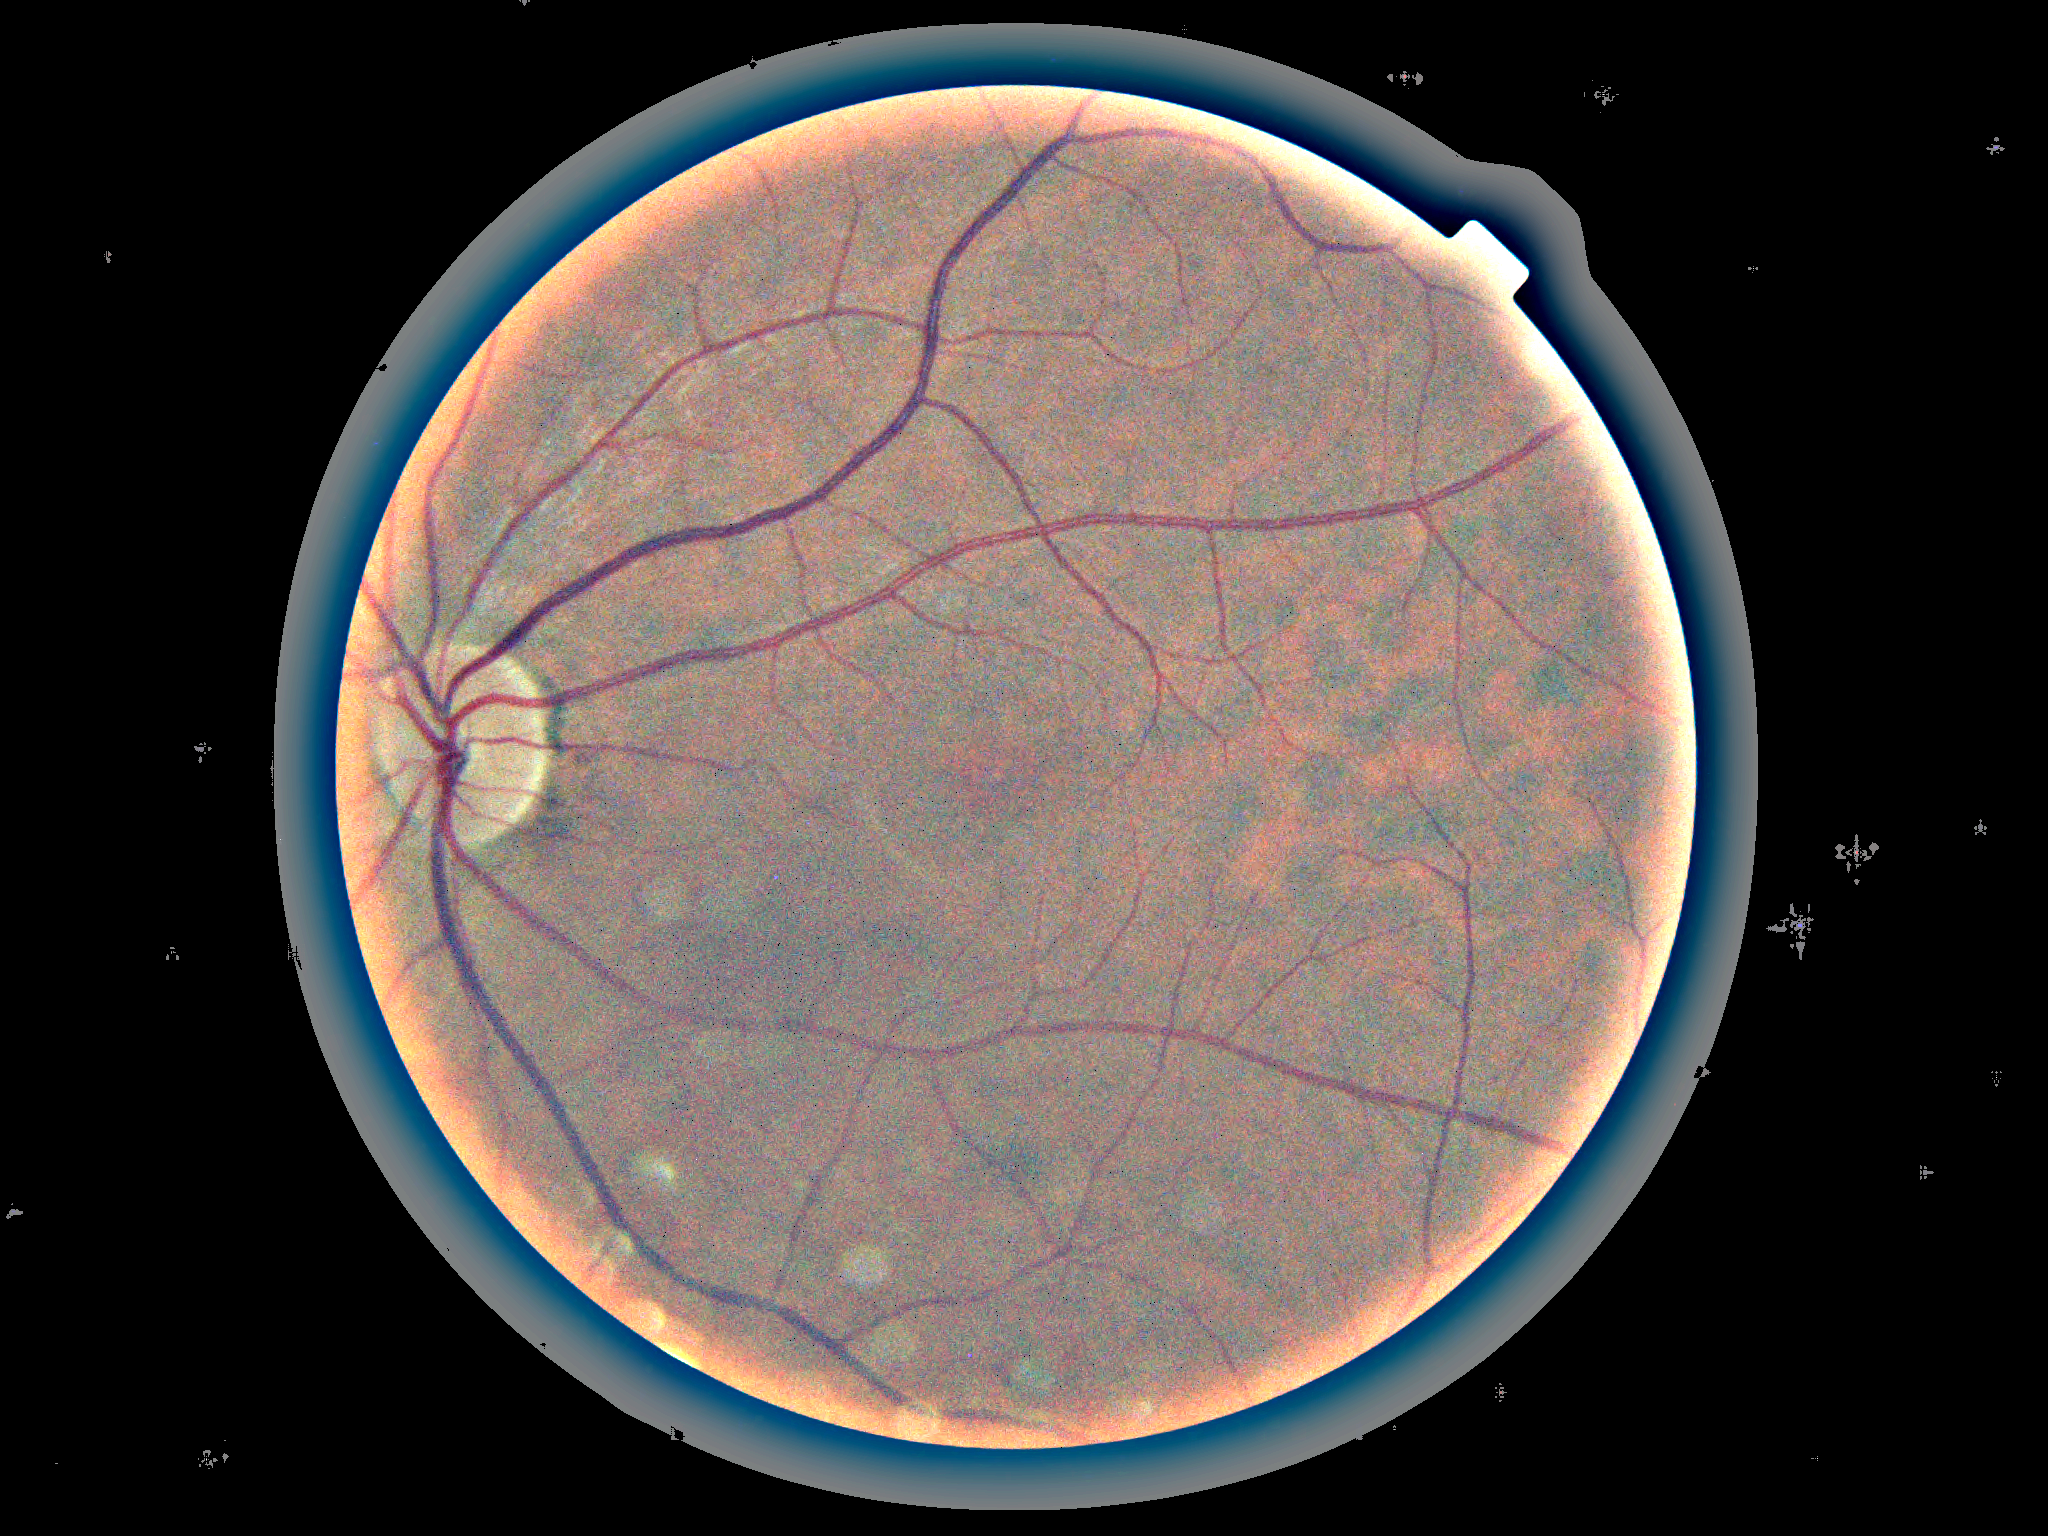

In [739]:
original.mask((128,128,128), replacement=(0,0,0,), inplace=True)
original.im

100%|██████████| 17034/17034 [07:21<00:00, 38.55it/s]


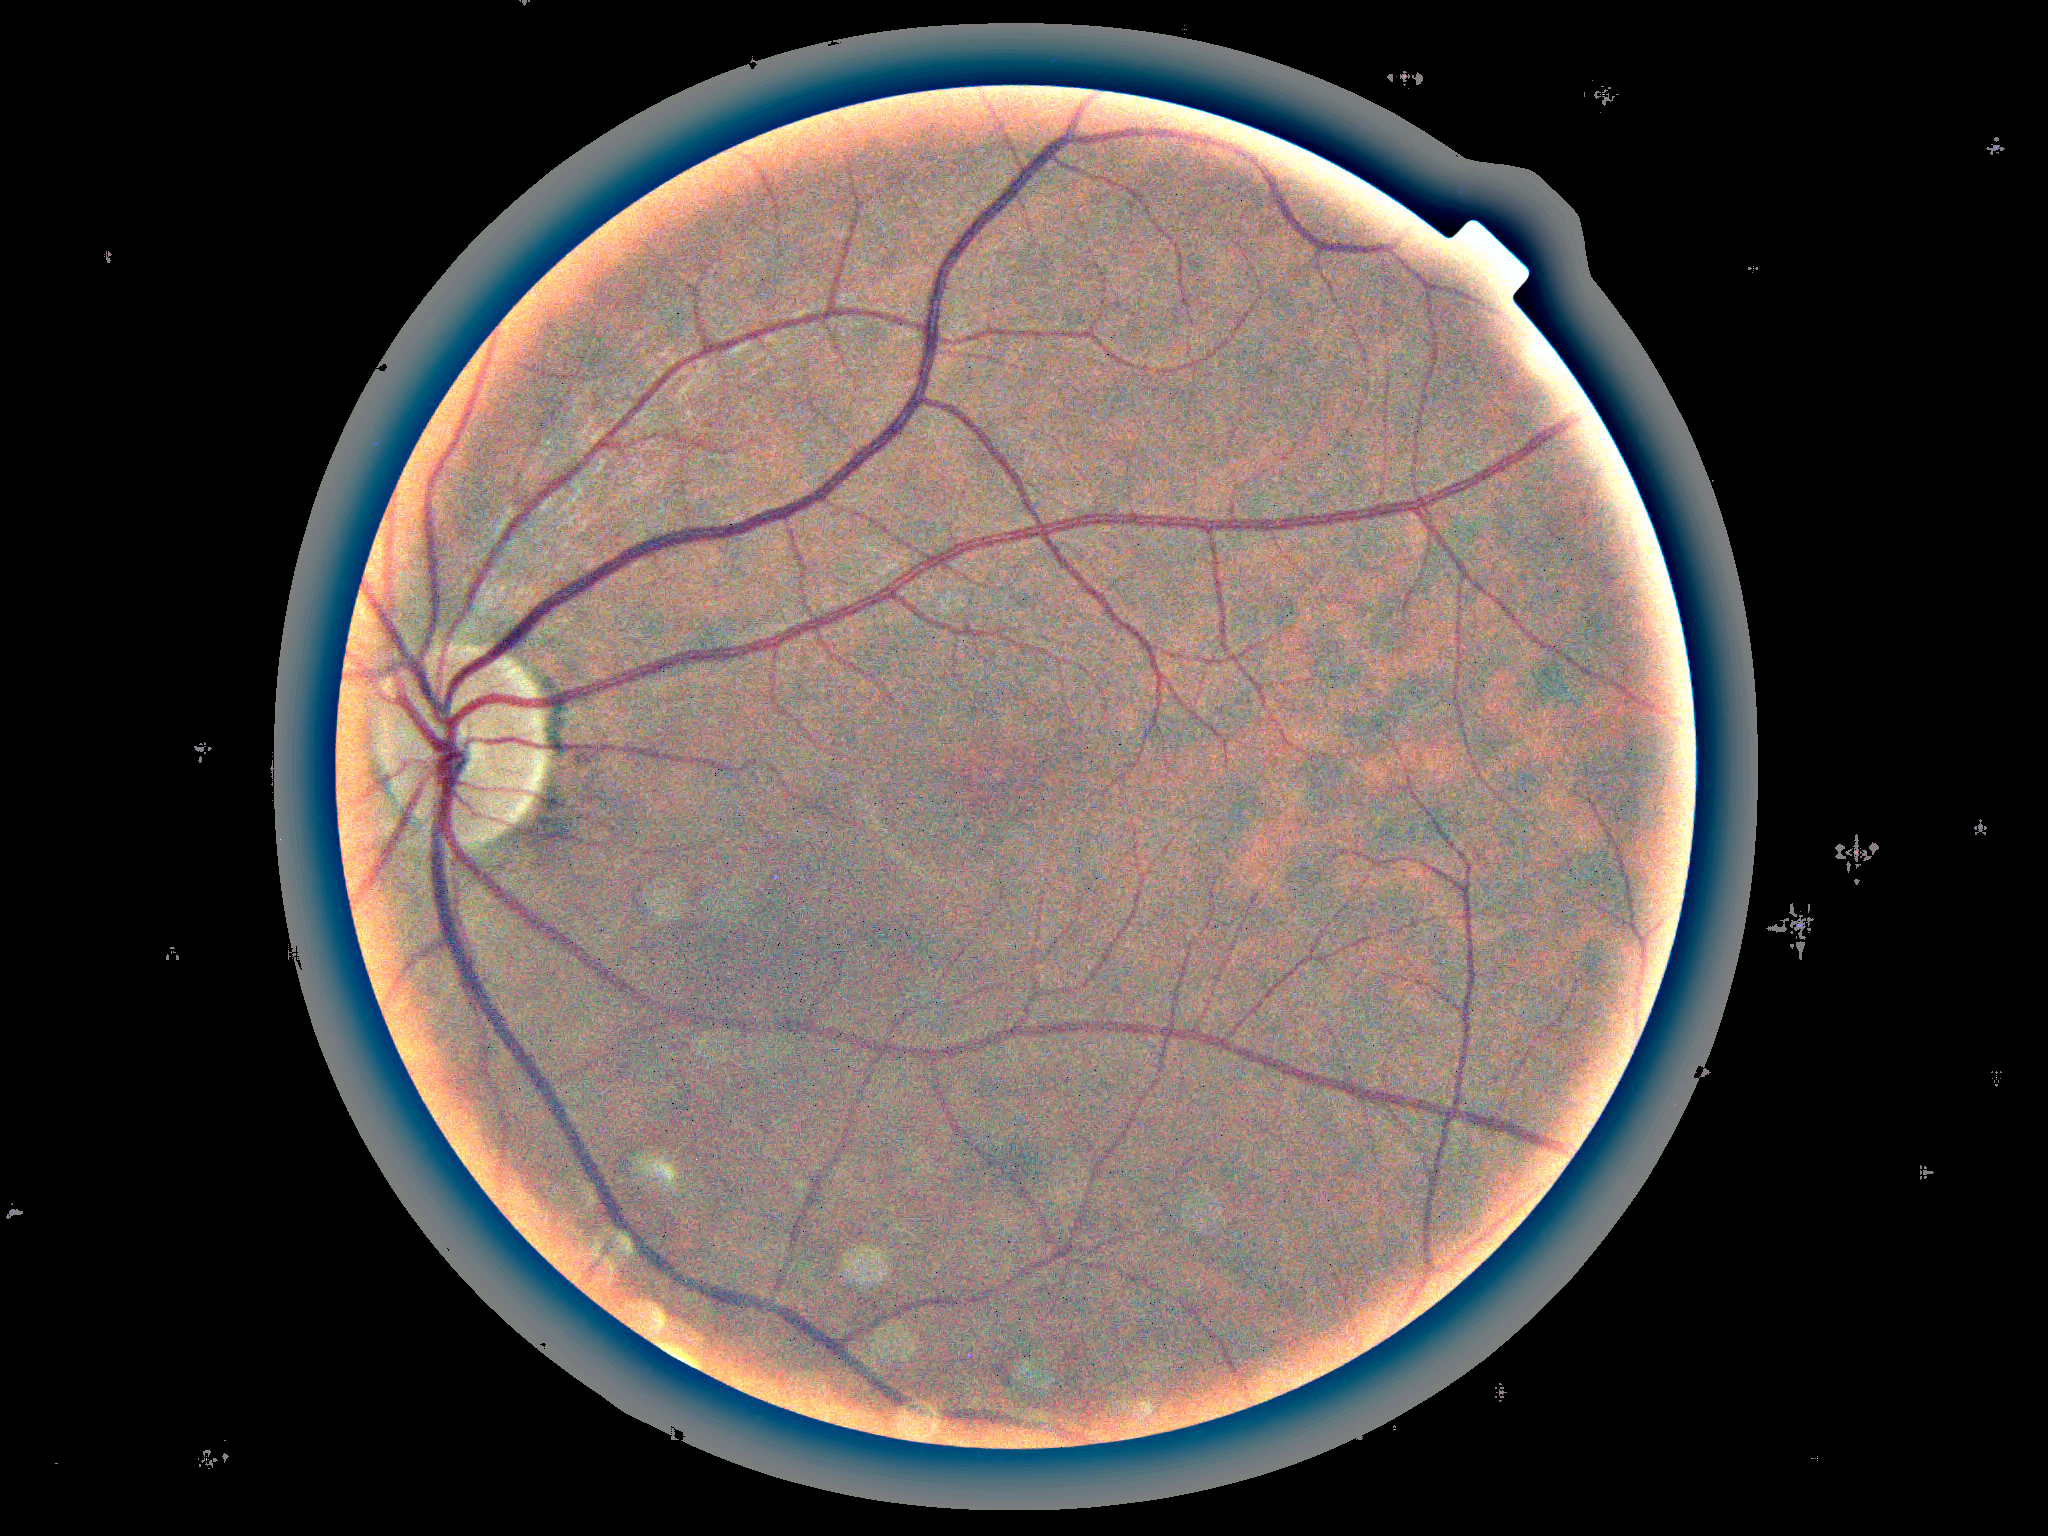

In [740]:
modified = cluster_pixels(original, len(original.palette)//2)
modified.im

In [742]:
len(modified.palette)

17034

In [749]:
def nearest_neighbour_mean(x):

    def cluster(x):
        out = []
        # Iterate each row
        for i in range(len(x)):
            if i-1 < 0:
                out.append(torch.mean(x[i:i+2], dim=0))

            elif i+1 < len(x):
                frame = torch.stack([x[i-1], x[i+1]]).to("cuda")
                diffs = torch.stack([ abs(x[i]-x[i-1]), abs(x[i]-x[i+1])])
                index = torch.min(diffs, dim=0).indices[:,0]
                minvl = torch.stack([frame[j,i,:] for i,j in enumerate(index)])
                out.append(torch.mean(torch.stack([minvl, x[i]]), dim=0))

            else:
                out.append(torch.mean(x[i-1:i+1], dim=0))
        # Stack 
        out = torch.stack(out, dim=0)
        return out.type(torch.int16)
    
    # Run clustering on data
    meaned_v = cluster(x)
    meaned_h = cluster(torch.transpose(x, 0, 1))
    
    return meaned_v, meaned_h

In [750]:
arr = np.asarray(original.im)
arr = torch.tensor(arr).to("cuda").type(torch.float32)

In [751]:
arr_nnm_v, arr_nnm_h = nearest_neighbour_mean(arr)

In [752]:
mod = Image.fromarray(arr_nnm.to("cpu").numpy().astype(np.uint8))
mod = Fundus(mod)

In [753]:
len(mod._get_palette())

114220

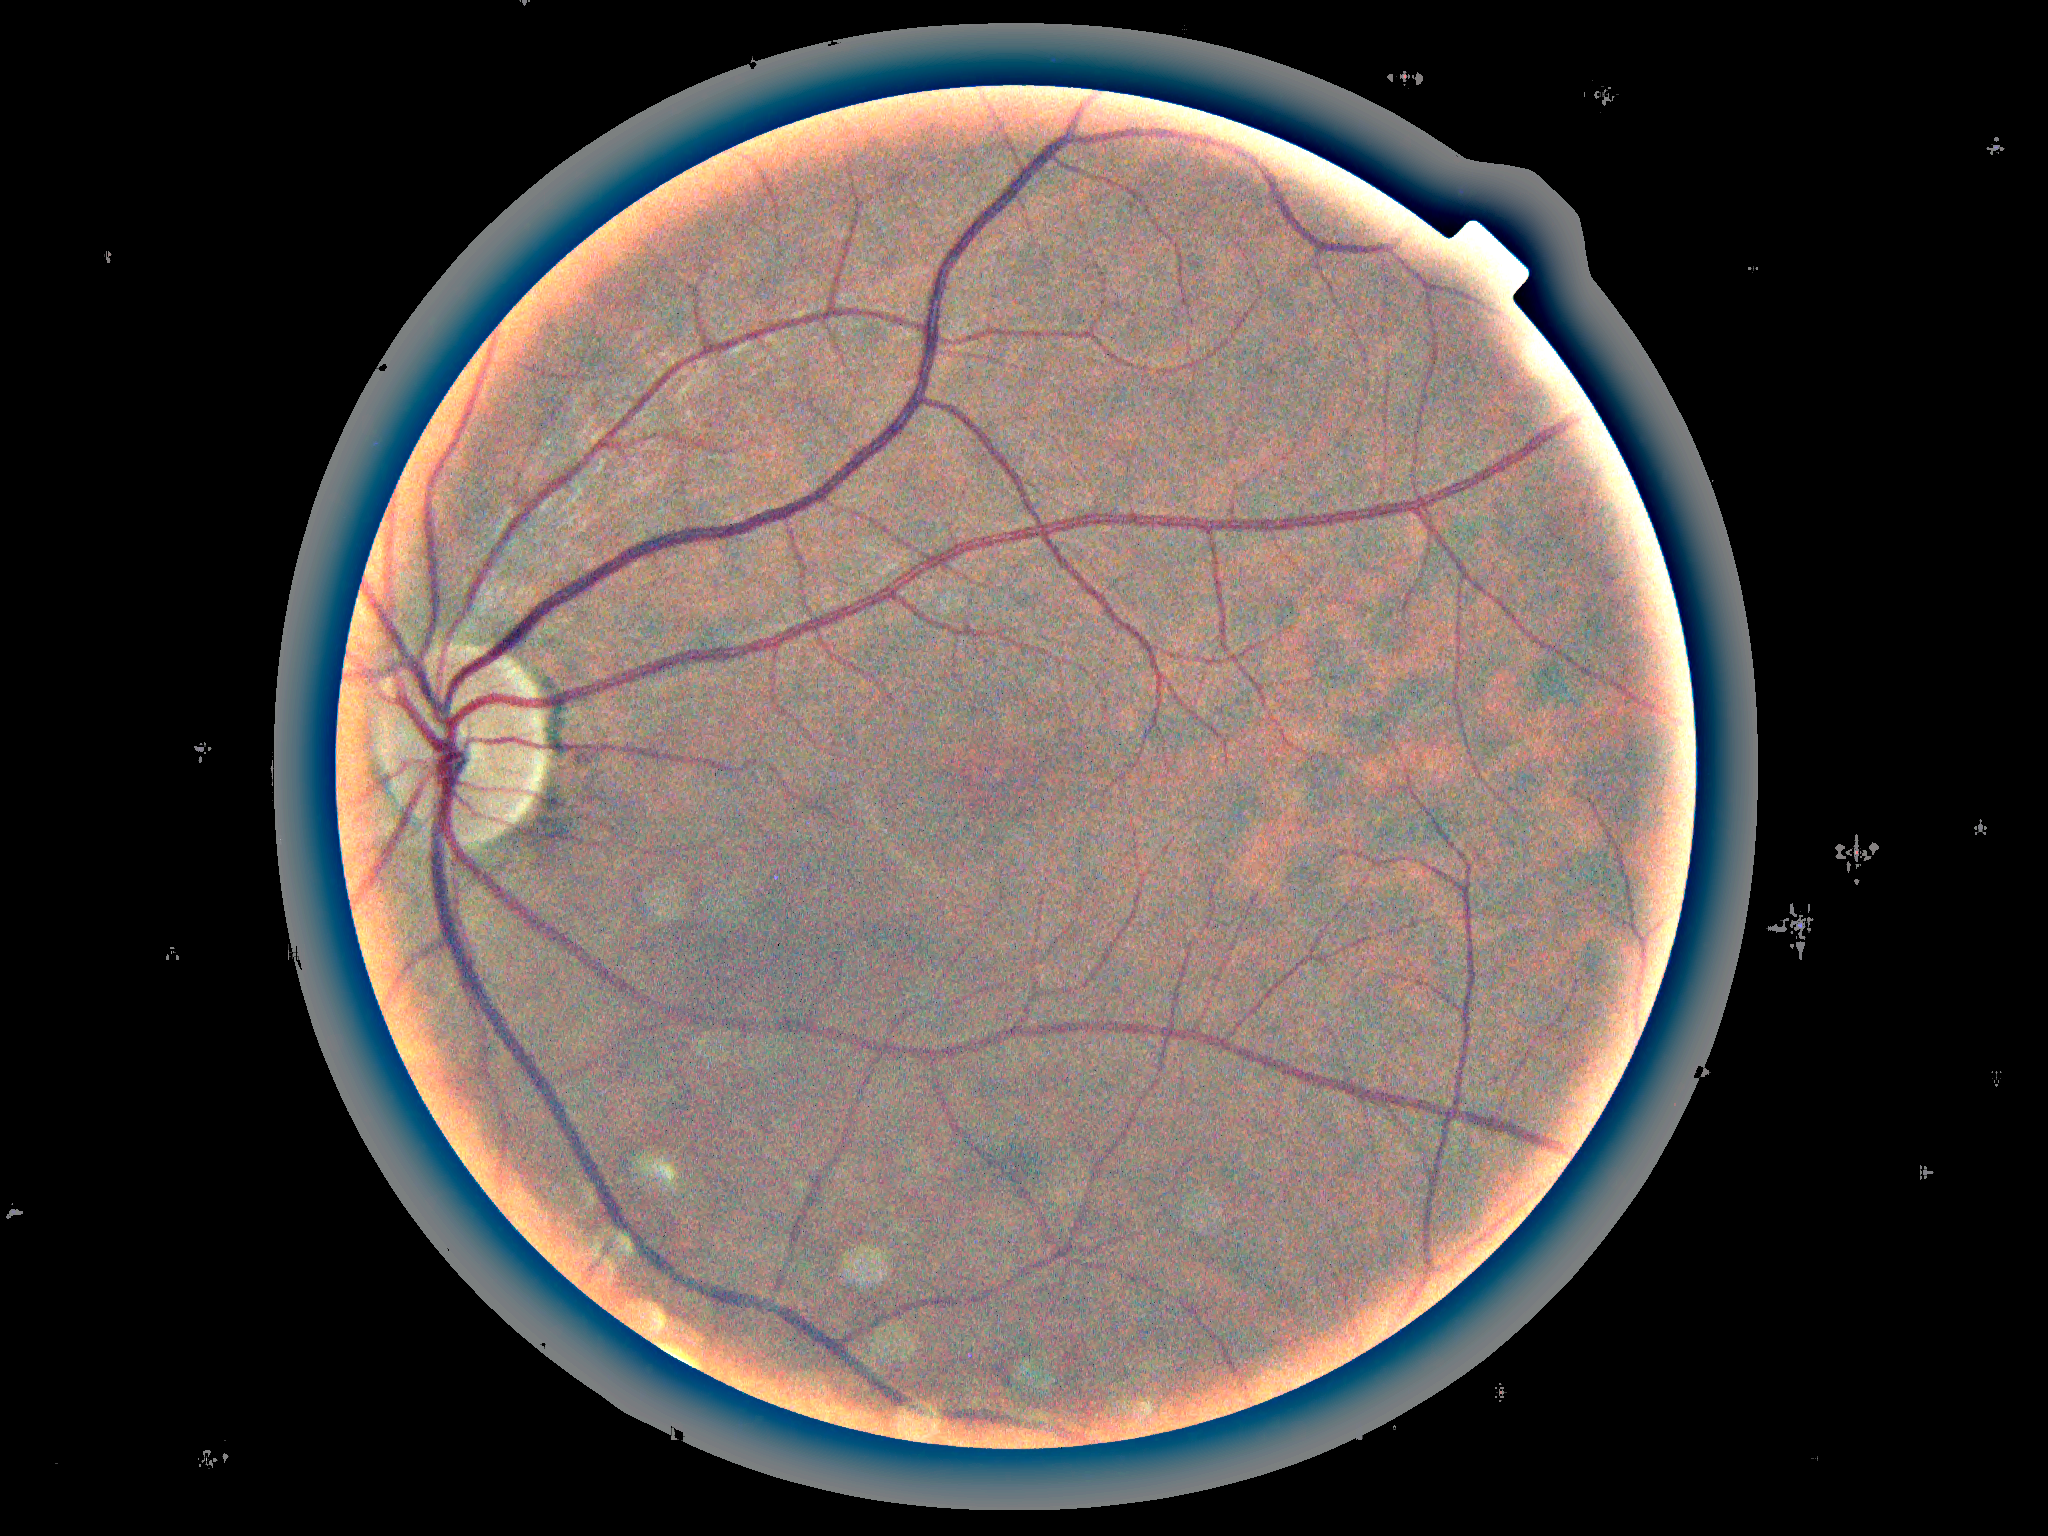

In [754]:
mod.im